In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sns.set(style="whitegrid")

# FIFA 2019 - Kaggle Dataset
## https://www.kaggle.com/karangadiya/fifa19

# É possível prever o valor de mercado de um jogador de futebol de acordo com as suas características físicas e capacidade técnica ?

#### Rotinas utilitárias

In [2]:
def removeColunas(df, attrs):
    to_keep=[i for i in df.columns.values.tolist() if i not in attrs]
    resultado = df[to_keep]
    return resultado
  
def criaDummiesAttrs(df, attrs, prefix=""):
    for var in attrs:
        cat_list = pd.get_dummies(df[var], prefix = var + prefix)
        df = df.join(cat_list)
    df = removeColunas(df, attrs)
    return df

ATTR_RESPONSE = "Value"


In [3]:
# leitura do dataset
df = pd.read_csv('fifa2019-data.csv')

# setando o index
df.set_index("ID", drop=True, inplace=True)

### Limpar atributos que não são características físicas OU capacidade técnica

In [4]:
df.drop(["Unnamed: 0", "Release Clause", "International Reputation", "Contract Valid Until", "Real Face", "Jersey Number", 'Overall', 'Potential',
         "Club", "Club Logo", "Photo", "Nationality", "Loaned From", "Joined", "Wage", "Special", "Flag"], axis=1, inplace=True)

df.drop(['Position', 'LS','ST','RS','LW','LF','CF','RF','RW','LAM',                
'CAM','RAM','LM','LCM','CM','RCM',
'RM','LWB','LDM','CDM','RDM','RWB',                
'LB','LCB','CB','RCB','RB'], axis=1, inplace=True)


In [5]:
df.describe()

,Age,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,2.947299,2.361308,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,0.660456,0.756164,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,1.000000,1.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,3.000000,2.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,3.000000,2.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,3.000000,3.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,5.000000,5.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


### Ajustando nomes das colunas com branco

In [6]:
for attr in df.columns.values:
  if(" " in attr):
    novoAttr = attr.replace(" ", "_")
    df[novoAttr] = df[attr]
    df = removeColunas(df, [attr])

### Tratamento de valores NA

In [7]:
print("Total de valores NA no dataset", df.isna().sum().sum())
df.dropna(how='any', inplace=True)

Total de valores NA no dataset 1968


### Conversões de conteúdo de atributo: Altura, Peso e Valor de mercado 

In [8]:
# Conversão de unidade de medida, ALTURA, de polegada para centimetros
df['Height'] = df.Height.str.replace("'",".").apply(lambda x: float(x)*30.48)

# Conversão de unidade de medida, PESO, de libras para kilo
df['Weight'] = df.Weight.str.replace("lbs", "").apply(lambda x: float(x)*0.45359237)

In [9]:
# Conversão do atributo VALOR, de caracter para valor decimal em Milhares de Euros
attr = 'Value'

def func(x):
    s = str(x).replace("€", "")
    if("." in s):
        s = s.replace(".", "").replace("M","00000").replace("K", "00")
    else:
        s = s.replace("M","000000").replace("K", "000")
    
    s = float(s) / 1000000

    return s

df[attr] = df[attr].apply(func)   
df[attr].fillna(0, inplace=True)

### Ajustando conteudo dos atributos Body_Type e Work_Rate

In [10]:
# Ajustando o Body Type
df.loc[158023,'Body_Type'] = "Normal"
df.loc[190871,'Body_Type'] = "Normal"
df.loc[193348,'Body_Type'] = "Normal"
df.loc[156321,'Body_Type'] = "Normal"
df.loc[192119,'Body_Type'] = "Normal"
df.loc[209331,'Body_Type'] = "Normal"
df.loc[20801,'Body_Type'] = "Normal"
print(df['Body_Type'].value_counts())

print("")

# Retirando BRANCOS do Work Rate
df["Work_Rate"] = df["Work_Rate"].apply(lambda x: x.replace(" ", "").replace("/", ""))
print(df['Work_Rate'].value_counts())

Normal    10602
Lean       6417
Stocky     1140
Name: Body_Type, dtype: int64

MediumMedium    9810
HighMedium      3173
MediumHigh      1690
HighHigh        1015
MediumLow        850
HighLow          699
LowMedium        449
LowHigh          439
LowLow            34
Name: Work_Rate, dtype: int64


## Analise Exploratoria de Dados (AED)

### Variável Resposta: Valor de Mercado em Milhões de EUROS

count    18159.000000
mean         2.416131
std          5.601319
min          0.000000
25%          0.300000
50%          0.675000
75%          2.000000
max        118.500000
Name: Value, dtype: float64


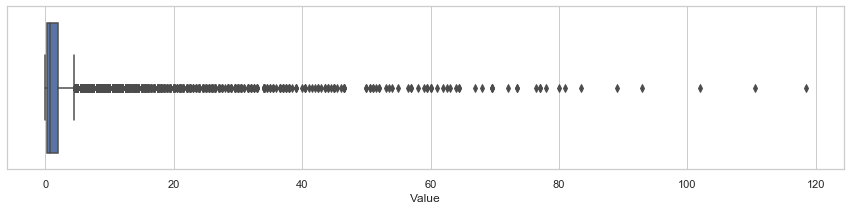

In [11]:
plt.figure(figsize=(15,3))
print(df.Value.describe())
ax = sns.boxplot(x=df[ATTR_RESPONSE])

### Valores com grande variância. O 3Quartil tem valor de 2M e o maior valor é de 118M.

### Jogadores com valor maior ou igual a 80M

In [12]:
df.loc[df[ATTR_RESPONSE]>=80, ['Name', 'Age', 'Value']].sort_values(by=[ATTR_RESPONSE], ascending=False)

,Name,Age,Value
ID,,,
190871,Neymar Jr,26,118.5
158023,L. Messi,31,110.5
192985,K. De Bruyne,27,102.0
183277,E. Hazard,27,93.0
211110,P. Dybala,24,89.0
202126,H. Kane,24,83.5
231747,K. Mbappé,19,81.0
176580,L. Suárez,31,80.0


### Atributos com Correlação Absoluta > 0.75 em mais de 20% das colunas

In [13]:
corrMatrix = df.loc[:, df.columns != ATTR_RESPONSE].corr()

for attr in corrMatrix.columns.values:
    peCorr = round((corrMatrix[attr][abs(corrMatrix[attr]) > 0.75].count()-1)*100/corrMatrix.shape[0],2)
    if(peCorr > 20):
        print(attr, peCorr) 

Finishing 20.51
ShortPassing 20.51
Volleys 20.51
Dribbling 43.59
Curve 30.77
BallControl 46.15
ShotPower 25.64
LongShots 30.77
Positioning 28.21
Penalties 20.51


## AED - Características Físicas do Jogador

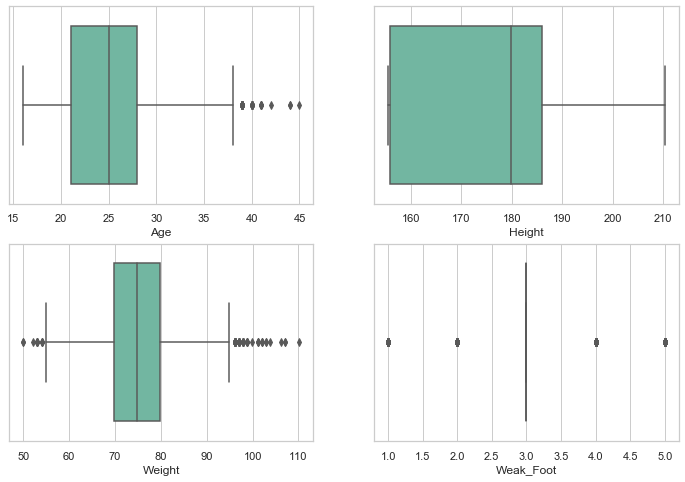

In [14]:
row = 0
col = 0
MAX_COLS = 2

fig, axs = plt.subplots(2, MAX_COLS, figsize=(12,8))

for i, attr in enumerate(['Age', 'Height', 'Weight', 'Weak_Foot']):
  sns.boxplot(x=df[attr], palette="Set2", ax=axs[row, col])
  col = col + 1
  if((i+1) % MAX_COLS == 0):
    row = row + 1
    col = 0


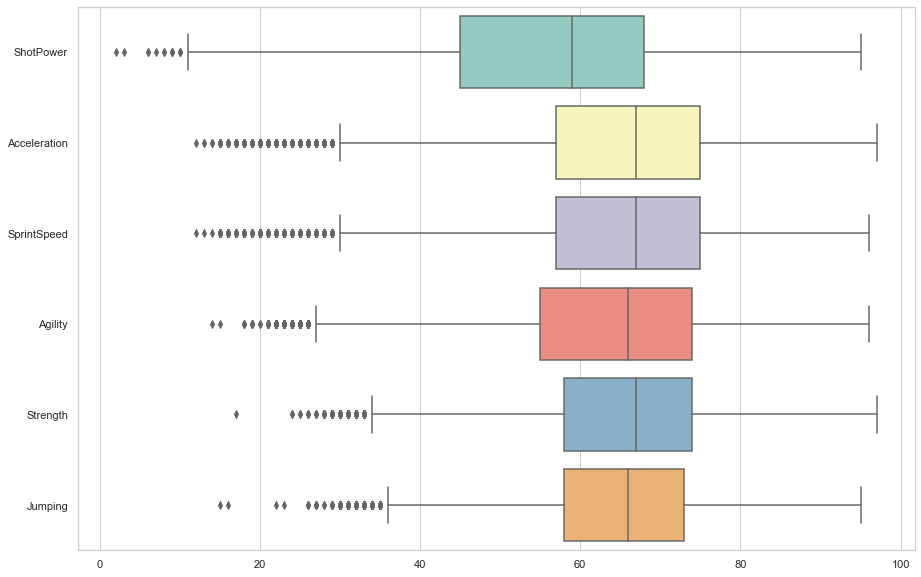

In [15]:
plt.figure(figsize=(15,10))
 
ax = sns.boxplot(data=df[['ShotPower', 'Acceleration', 'SprintSpeed', 'Agility','Strength', 'Jumping']], orient="h", palette="Set3")


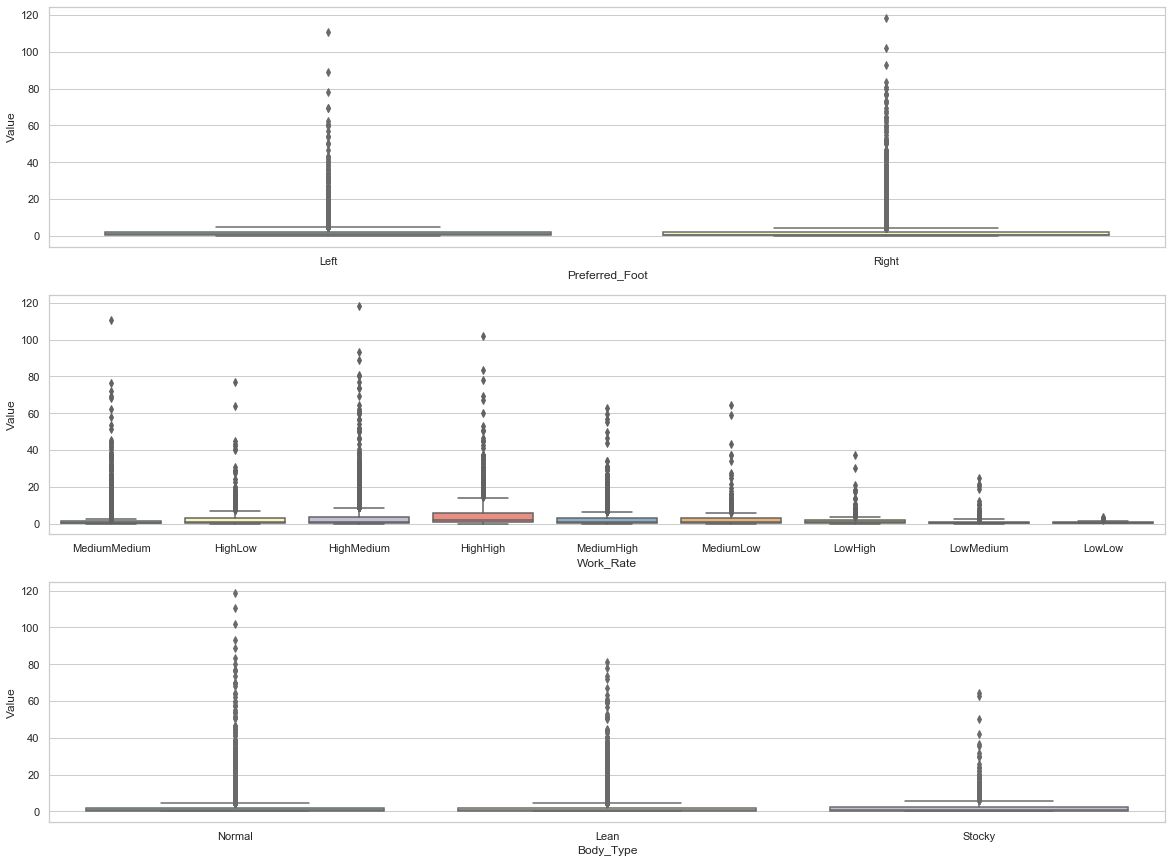

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(20, 15))

for i, attr in enumerate(['Preferred_Foot', 'Work_Rate', 'Body_Type']):
  sns.boxplot(x=df[attr], y=df[ATTR_RESPONSE], palette="Set3", ax=axs[i])

## AED - Capacidade Técnica do Jogador

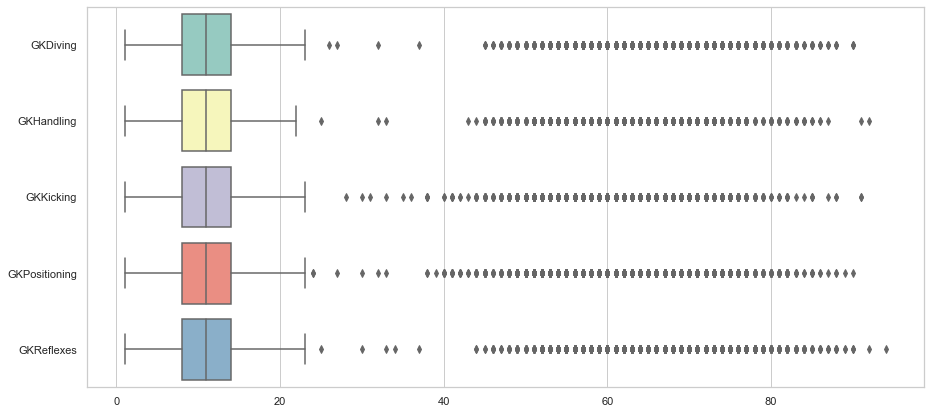

In [17]:
plt.figure(figsize=(15,7))
 
ax = sns.boxplot(data=df[['GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']], orient="h", palette="Set3")


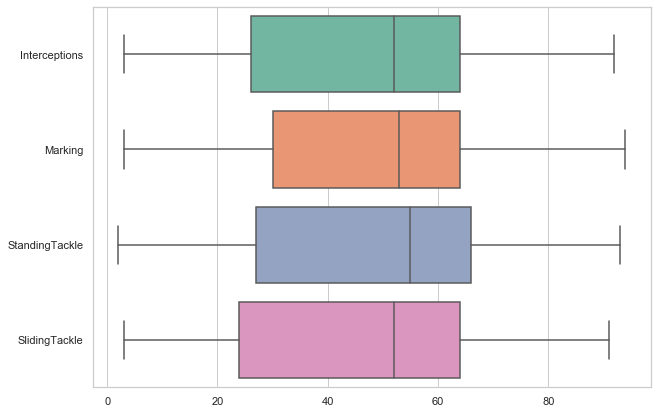

In [18]:
plt.figure(figsize=(10,7))
 
ax = sns.boxplot(data=df[['Interceptions', 'Marking', 'StandingTackle', 'SlidingTackle']], orient="h", palette="Set2")


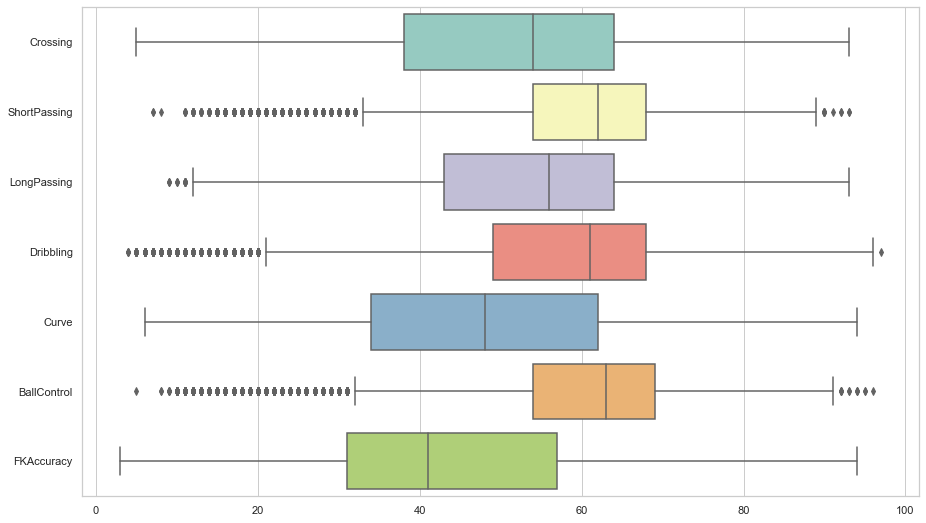

In [19]:
plt.figure(figsize=(15,9))
 
ax = sns.boxplot(data=df[['Crossing', 'ShortPassing', 'LongPassing', 'Dribbling', 'Curve',  'BallControl', 'FKAccuracy']], orient="h", palette="Set3")

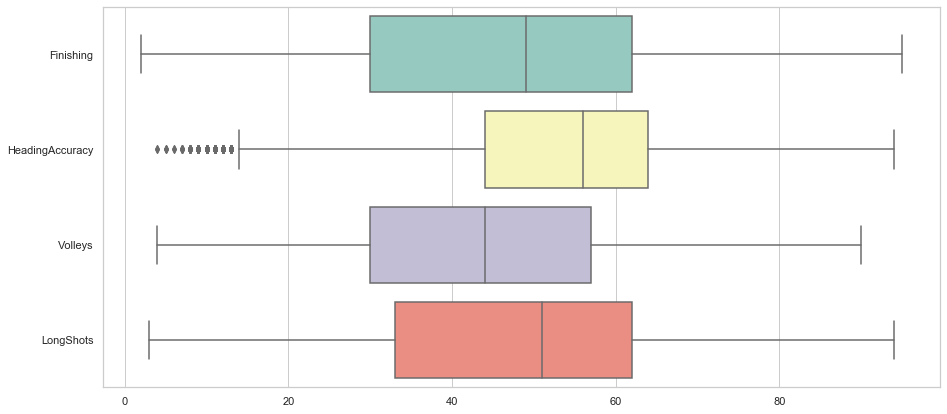

In [20]:
plt.figure(figsize=(15,7))
 
ax = sns.boxplot(data=df[['Finishing', 'HeadingAccuracy', 'Volleys',  'LongShots']], orient="h", palette="Set3")

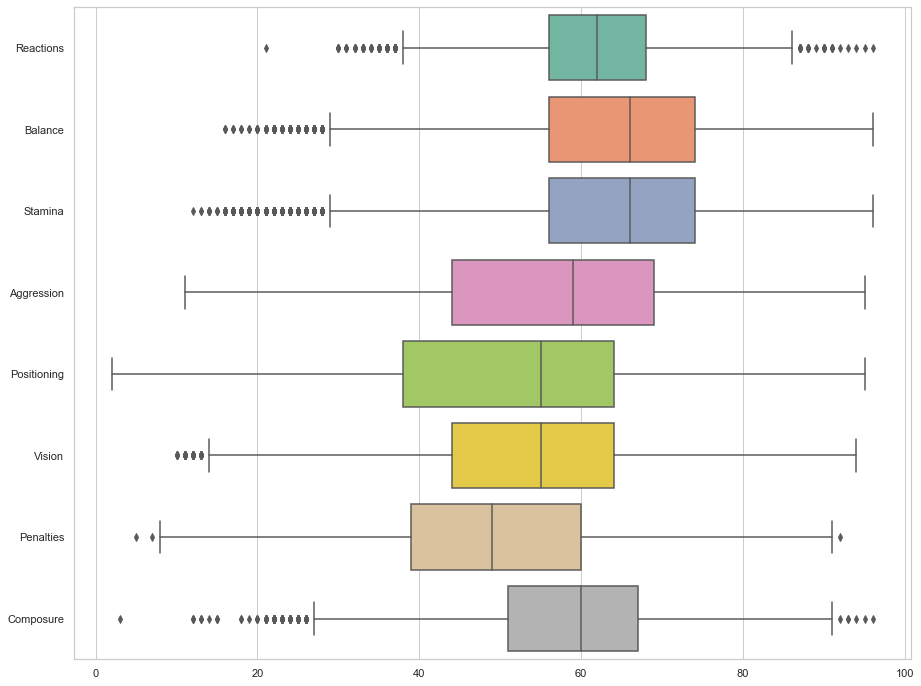

In [21]:
plt.figure(figsize=(15,12))

ax = sns.boxplot(data=df[['Reactions', 'Balance', 'Stamina', 'Aggression', 'Positioning', 'Vision', 'Penalties', 'Composure']], orient="h", palette="Set2")

### Conversão de atributos categóricos através do HotEncodeMachine

In [22]:
hotMachineE = []

for attr in df.columns:
  if(attr != "Name"):
    if(df[attr].dtype == "object"):
      hotMachineE.append(attr)

print(hotMachineE)

df = criaDummiesAttrs(df, hotMachineE, "_DMS")

['Preferred_Foot', 'Work_Rate', 'Body_Type']


# Avaliação de Modelo de Regressão Linear para predição do Valor de Mercado

### Devido a alta variação do atributo RESPOSTA, vamos fazer a analise em dois CLUSTERS, com uma linha de corte em EU$ 2M (3 Quartil)

In [23]:
print(df.Value.describe())

count    18159.000000
mean         2.416131
std          5.601319
min          0.000000
25%          0.300000
50%          0.675000
75%          2.000000
max        118.500000
Name: Value, dtype: float64


### Separação do dataset em DOIS, Standard e Star

In [24]:
dfStar = df[df[ATTR_RESPONSE] > 2].copy()
dfStandard = df[df[ATTR_RESPONSE] <= 2].copy()

### BoxPlot Star

count    4491.000000
mean        7.990247
std         9.218577
min         2.100000
25%         3.200000
50%         5.000000
75%         9.000000
max       118.500000
Name: Value, dtype: float64


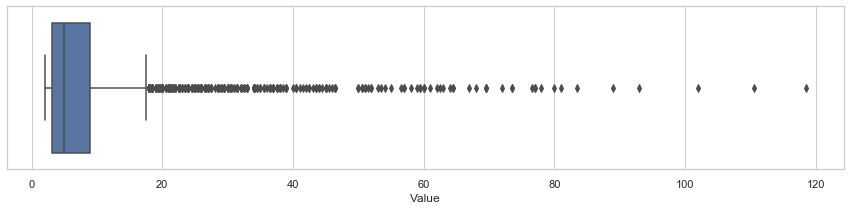

In [25]:
plt.figure(figsize=(15,3))
print(dfStar.Value.describe())
ax = sns.boxplot(x=dfStar[ATTR_RESPONSE])

### BoxPlot Standard

count    13668.000000
mean         0.584601
std          0.448173
min          0.000000
25%          0.230000
50%          0.475000
75%          0.825000
max          2.000000
Name: Value, dtype: float64


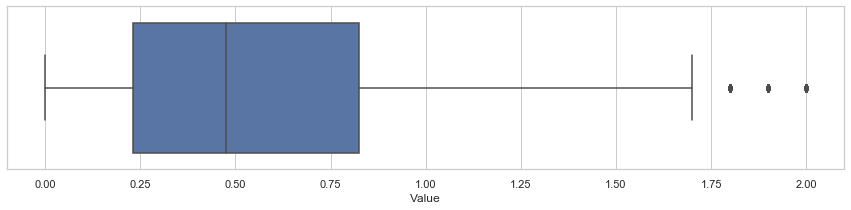

In [26]:
plt.figure(figsize=(15,3))
print(dfStandard.Value.describe())
ax = sns.boxplot(x=dfStandard[ATTR_RESPONSE])

### Modelo de regressão linear para o Standard

In [27]:
print("dfStandard")

attrToTestStd = []

attrToRemoveStd = ['Weight', 'Crossing', 'Finishing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
                   'Acceleration', 'Agility', 'Weak_Foot', 'Penalties', 'Vision', 'Interceptions', 'Aggression']

for attr in dfStandard.columns:
  if(attr not in ['Name', ATTR_RESPONSE] + attrToRemoveStd):
    attrToTestStd.append(attr)

X = dfStandard[attrToTestStd]

y = dfStandard[ATTR_RESPONSE]

X = sm.add_constant(X) # adding a constant

X_train,X_test,y_train,y_test = train_test_split(X, y.ravel(), test_size = 0.3, random_state = 817362)

modelStd = sm.OLS(y_train, X_train).fit()
 
print_model = modelStd.summary()

print(print_model.tables[0])

y_pred = modelStd.predict(X_test)


dfStandard
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     271.3
Date:                Sun, 22 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:38:28   Log-Likelihood:                -2484.5
No. Observations:                9567   AIC:                             5043.
Df Residuals:                    9530   BIC:                             5308.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         


### R² Ajustado é de apenas 0.50, considerado baixo

### Avaliação dos resultados

In [28]:
print("MSE para Standard", metrics.mean_squared_error(y_test, y_pred))

MSE para Standard 0.10158024155821666


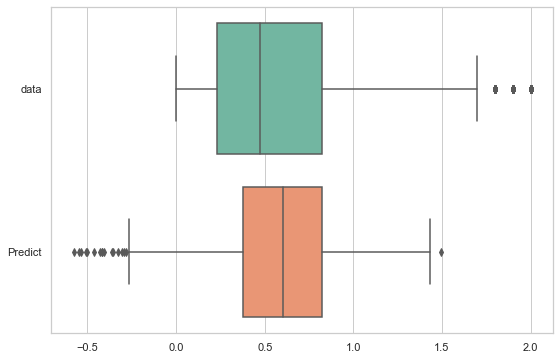

In [29]:
fig, ax = plt.subplots(figsize=(9,6))
dfY=pd.DataFrame(zip(*[y_test, y_pred]), columns=['data','Predict'])
ax = sns.boxplot(data=dfY[['data', 'Predict']], orient="h", palette="Set2")

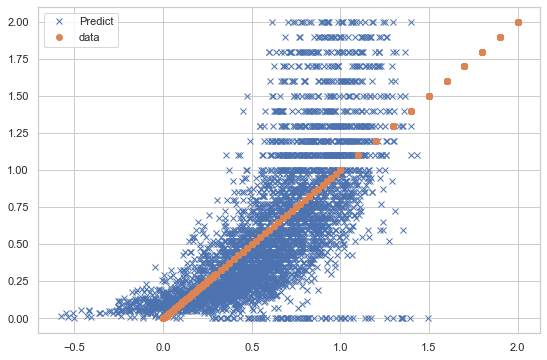

In [30]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(y_pred, y_test, 'x', label="Predict")
ax.plot(y_test, y_test, 'o', label="data")
ax.legend(loc='best');

### Modelo de regressão linear para o Star

In [31]:
print("dfStar")

attrToTestStar = []

attrToRemoveStar = ['Crossing', 'Volleys', 'Curve', 'Agility', 'Balance', 'ShotPower', 'Jumping', 'Stamina',
                    'Interceptions','Vision','Penalties','StandingTackle', 'GKKicking','Skill_Moves']

for attr in dfStar.columns:
  if(attr not in ['Name', ATTR_RESPONSE] + attrToRemoveStar):
    attrToTestStar.append(attr)

X = dfStar[attrToTestStar]

y = dfStar[ATTR_RESPONSE]

X = sm.add_constant(X) # adding a constant

X_train,X_test,y_train,y_test = train_test_split(X, y.ravel(), test_size = 0.3, random_state = 817362)

modelStar = sm.OLS(y_train, X_train).fit()
 
print_model = modelStar.summary()

print(print_model.tables[0])

y_pred = modelStar.predict(X_test)

dfStar
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     108.7
Date:                Sun, 22 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:38:29   Log-Likelihood:                -10206.
No. Observations:                3143   AIC:                         2.049e+04
Df Residuals:                    3106   BIC:                         2.071e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         


### R² Ajustado é de apenas 0.55, considerado baixo

### Avaliação dos resultados

In [32]:
print("MSE para Star", metrics.mean_squared_error(y_test, y_pred))

MSE para Star 36.904151036581226


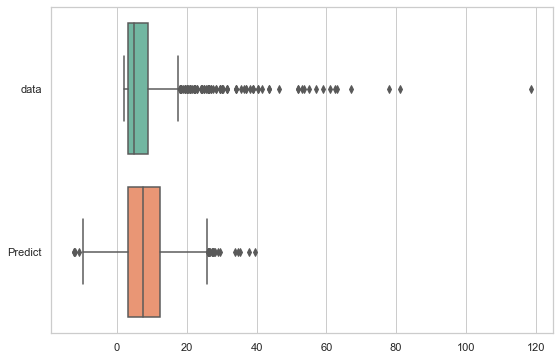

In [33]:
fig, ax = plt.subplots(figsize=(9,6))
dfY=pd.DataFrame(zip(*[y_test, y_pred]), columns=['data','Predict'])
ax = sns.boxplot(data=dfY[['data', 'Predict']], orient="h", palette="Set2")

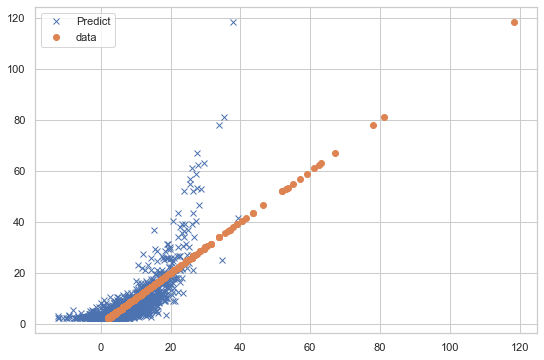

In [34]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(y_pred, y_test, 'x', label="Predict")
ax.plot(y_test, y_test, 'o', label="data")
ax.legend(loc='best');

## Comparação de atributos utilizados em cada modelo

In [35]:
print("Atributos de STANDARD e STAR", [x for x in attrToTestStd if x in attrToTestStar])

Atributos de STANDARD e STAR ['Age', 'Height', 'HeadingAccuracy', 'ShortPassing', 'LongPassing', 'BallControl', 'SprintSpeed', 'Reactions', 'Strength', 'LongShots', 'Positioning', 'Composure', 'Marking', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKPositioning', 'GKReflexes', 'Preferred_Foot_DMS_Left', 'Preferred_Foot_DMS_Right', 'Work_Rate_DMS_HighHigh', 'Work_Rate_DMS_HighLow', 'Work_Rate_DMS_HighMedium', 'Work_Rate_DMS_LowHigh', 'Work_Rate_DMS_LowLow', 'Work_Rate_DMS_LowMedium', 'Work_Rate_DMS_MediumHigh', 'Work_Rate_DMS_MediumLow', 'Work_Rate_DMS_MediumMedium', 'Body_Type_DMS_Lean', 'Body_Type_DMS_Normal', 'Body_Type_DMS_Stocky']


In [36]:
print("Atributos de STANDARD que não estão em STAR", [x for x in attrToTestStd if x not in attrToTestStar])

Atributos de STANDARD que não estão em STAR ['Balance', 'ShotPower', 'Jumping', 'Stamina', 'StandingTackle', 'GKKicking', 'Skill_Moves']


In [37]:
print("Atributos de STAR que não estão em STANDARD", [x for x in attrToTestStar if x not in attrToTestStd])

Atributos de STAR que não estão em STANDARD ['Weight', 'Finishing', 'Dribbling', 'FKAccuracy', 'Acceleration', 'Aggression', 'Weak_Foot']


## Ambos R² ajustado foram baixos, vamos criar faixas de valores e fazer um classificador para prever o valor de mercado e avaliar se os resultados serão melhores

## Criação de FAIXAS para implementação de CLASSIFICADOR para avaliar se o resultado é MELHOR que a Regressão

## Criador de FAIXAS para utilizar um CLASSIFICADOR 

In [38]:
ATTR_RESPONSE = "RangeValue"

def criaRangeValue(x):
  resultado = "NI"

  if(x<=0.6):
    resultado='600K'
  elif(x<=2):
    resultado='2M'
  elif(x<=10):
    resultado='10M'
  else:
    resultado='+10M'

  return resultado;

df[ATTR_RESPONSE] = df['Value'].apply(criaRangeValue)

print(df[ATTR_RESPONSE].value_counts())


600K    8386
2M      5282
10M     3612
+10M     879
Name: RangeValue, dtype: int64


## Novo AED, agora com as faixas criadas

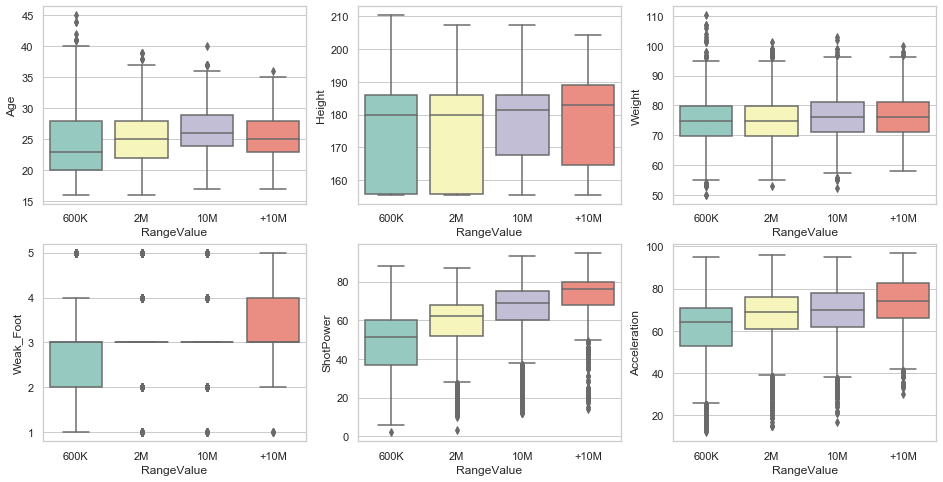

In [39]:
row = 0
col = 0
MAX_COLS = 3

fig, axs = plt.subplots(2, MAX_COLS, figsize=(16,8))

for i, attr in enumerate(['Age', 'Height', 'Weight', 'Weak_Foot','ShotPower','Acceleration']):
  sns.boxplot(x=df[ATTR_RESPONSE], y=df[attr], palette="Set3", ax=axs[row, col], order=['600K', '2M', '10M', '+10M'])
  col = col + 1
  if((i+1) % MAX_COLS == 0):
    row = row + 1
    col = 0


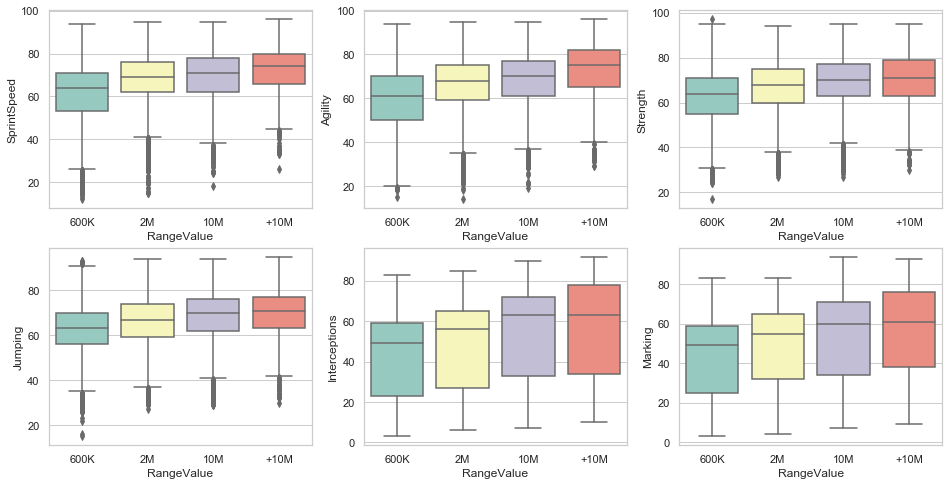

In [40]:
row = 0
col = 0
MAX_COLS = 3

fig, axs = plt.subplots(2, MAX_COLS, figsize=(16,8))

for i, attr in enumerate(['SprintSpeed', 'Agility','Strength', 'Jumping','Interceptions', 'Marking']):
  sns.boxplot(x=df[ATTR_RESPONSE], y=df[attr], palette="Set3", ax=axs[row, col], order=['600K', '2M', '10M', '+10M'])
  col = col + 1
  if((i+1) % MAX_COLS == 0):
    row = row + 1
    col = 0


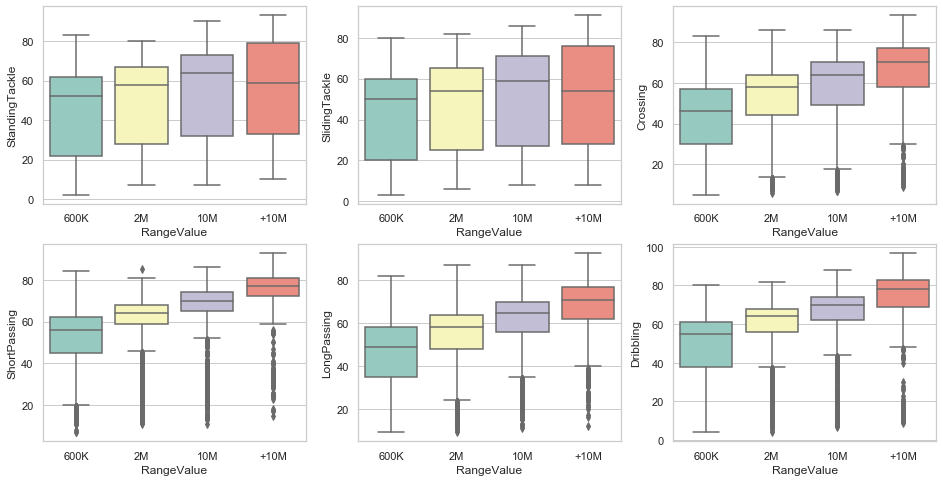

In [41]:
row = 0
col = 0
MAX_COLS = 3

fig, axs = plt.subplots(2, MAX_COLS, figsize=(16,8))

for i, attr in enumerate(['StandingTackle', 'SlidingTackle','Crossing', 'ShortPassing', 'LongPassing', 'Dribbling']):
  sns.boxplot(x=df[ATTR_RESPONSE], y=df[attr], palette="Set3", ax=axs[row, col], order=['600K', '2M', '10M', '+10M'])
  col = col + 1
  if((i+1) % MAX_COLS == 0):
    row = row + 1
    col = 0


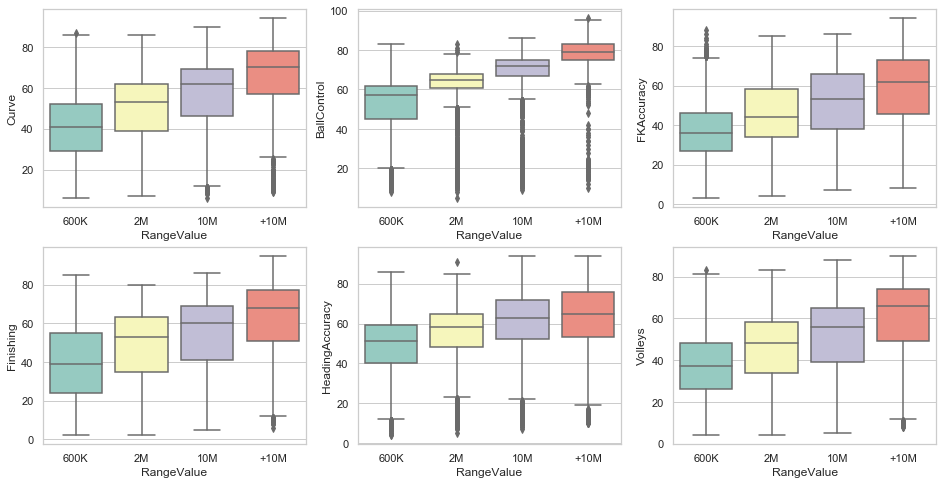

In [42]:
row = 0
col = 0
MAX_COLS = 3

fig, axs = plt.subplots(2, MAX_COLS, figsize=(16,8))

for i, attr in enumerate(['Curve','BallControl', 'FKAccuracy','Finishing', 'HeadingAccuracy', 'Volleys']):
  sns.boxplot(x=df[ATTR_RESPONSE], y=df[attr], palette="Set3", ax=axs[row, col], order=['600K', '2M', '10M', '+10M'])
  col = col + 1
  if((i+1) % MAX_COLS == 0):
    row = row + 1
    col = 0


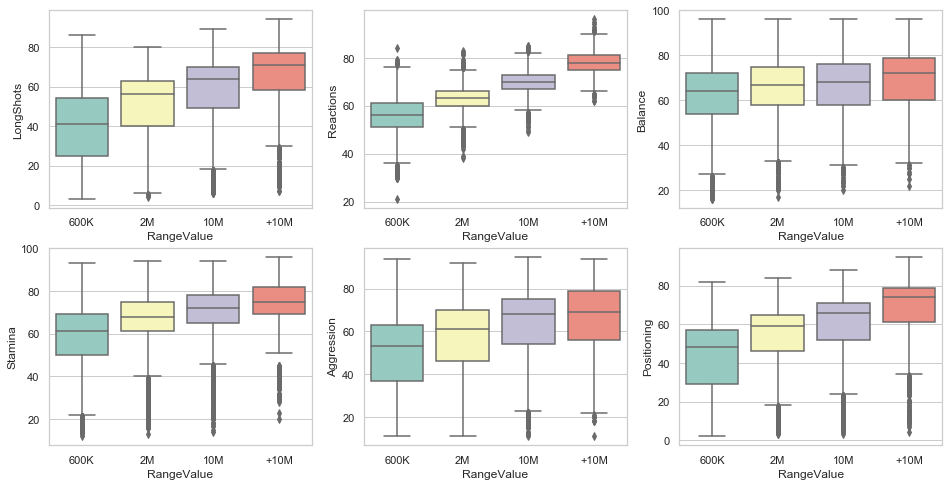

In [43]:
row = 0
col = 0
MAX_COLS = 3

fig, axs = plt.subplots(2, MAX_COLS, figsize=(16,8))

for i, attr in enumerate(['LongShots', 'Reactions', 'Balance', 'Stamina', 'Aggression', 'Positioning']):
  sns.boxplot(x=df[ATTR_RESPONSE], y=df[attr], palette="Set3", ax=axs[row, col], order=['600K', '2M', '10M', '+10M'])
  col = col + 1
  if((i+1) % MAX_COLS == 0):
    row = row + 1
    col = 0


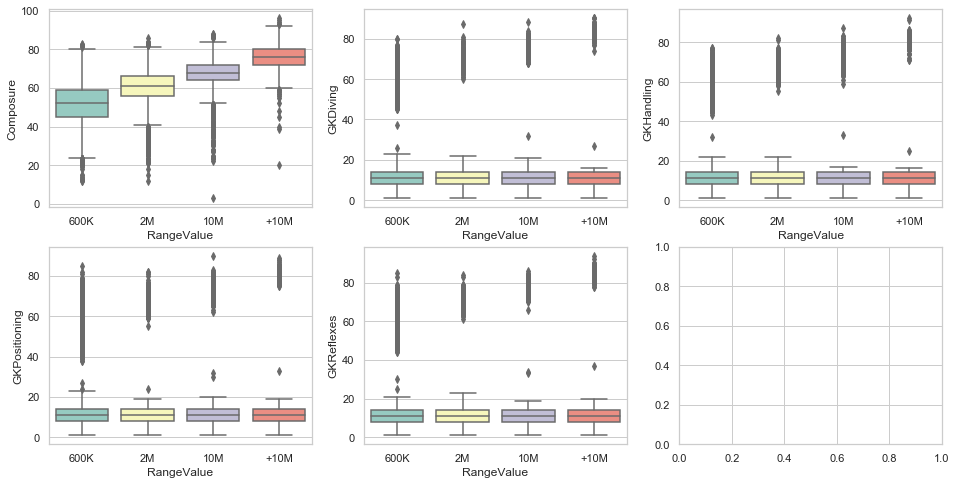

In [44]:
row = 0
col = 0
MAX_COLS = 3

fig, axs = plt.subplots(2, MAX_COLS, figsize=(16,8))

for i, attr in enumerate(['Composure', 'GKDiving', 'GKHandling', 'GKPositioning', 'GKReflexes']):
  sns.boxplot(x=df[ATTR_RESPONSE], y=df[attr], palette="Set3", ax=axs[row,col], order=['600K', '2M', '10M', '+10M'])
  col = col + 1
  if((i+1) % MAX_COLS == 0):
    row = row + 1
    col = 0


## Avaliação de Classificadores

In [45]:
attrToTest = []

for attr in df.columns:
  if(attr not in ['Name', 'Value', ATTR_RESPONSE]):
    attrToTest.append(attr)

X = df[attrToTest]

y = df[ATTR_RESPONSE]

X_train,X_test,y_train,y_test = train_test_split(X, y.ravel(), test_size = 0.3, random_state = 817362)

classifiers = [
    SVC(),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    KNeighborsClassifier(5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
]


for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(clf)
    
    print('****Results****')
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))



SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
****Results****
              precision    recall  f1-score   support

        +10M       0.87      0.55      0.67       244
         10M       0.78      0.81      0.80      1085
          2M       0.73      0.75      0.74      1595
        600K       0.89      0.90      0.89      2524

    accuracy                           0.82      5448
   macro avg       0.82      0.75      0.77      5448
weighted avg       0.82      0.82      0.82      5448

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
****Results****
              precision    recall  f1-score   support

        +10M       0.75      0.77      0.76       244
         10M       0.77      0.71      

### O melhor classificador é o GradientBoosting

# Não é possivel prever o valor de mercado de um jogador de futebol de acordo com as suas características físicas e capacidade técnica. Os valores de mercado apresentam uma variação muito grande, com isto não foi possível montar uma regressão linear multivariada com um grau de confiança aceitável.

# No entanto, criando-se faixas de valores é possivel criar um Classificador com o algoritmo de GradientBoosting que atinge um nível de acurácia aceitável. 